# **Exploratory Data Analysis of Movie Subtitles**

This is a short tutorial for DA623 on data analysis of text from subtitles of one of my favourite movies: 'Taare Zameen Par'. We shall use English subtitles obtained from the web. 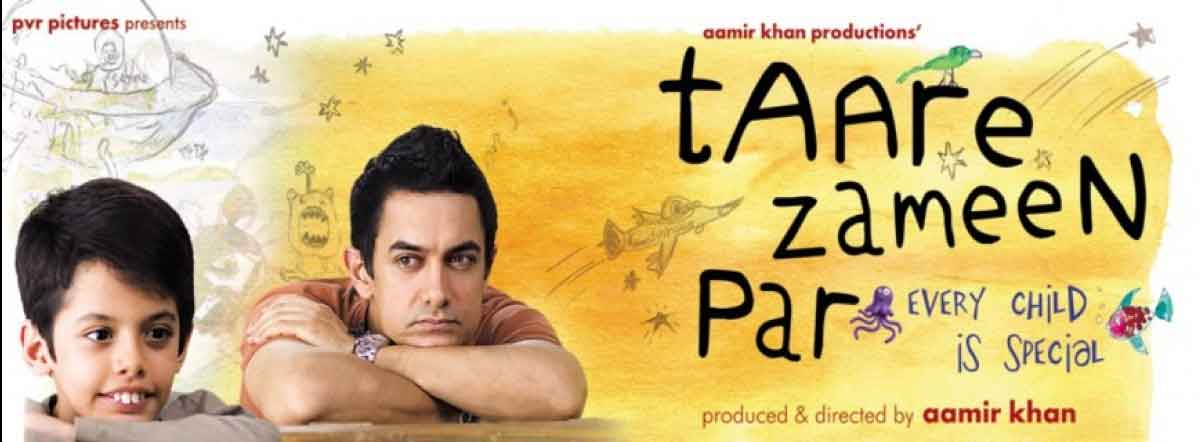

First we shall install and import the dependencies that will be required for our analysis.

In [93]:
!pip install pysrt datetime textblob matplotlib seaborn nltk numpy wordcloud

In [94]:
from datetime import date, datetime, timedelta, time
import re
import pysrt
import pandas as pd
from textblob import TextBlob
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
sns.set()
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 4.5)
style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We will use the [pysrt](https://pypi.org/project/pysrt/) library for handling the srt (Subtitle File).

In [95]:
# Location of the file to be put in the function below
subs = pysrt.open("/content/tzp.srt", encoding='iso-8859-1')

print("The length of the movie in hh:mm:ss:ms is " + str(subs[-1].end.to_time()))
print("The number of subtitles is " + str(len(subs)))

print("---------")
#Lets look at the first five subtitles
print(subs[:5].text)
#Pruning the useless (first) subtitle
del subs[0]
print("---------")
print("The first dialogue of the movie: " + subs[0].text)


The length of the movie in hh:mm:ss:ms is 02:35:17.390000
The number of subtitles is 1324
---------
Team xRG @ desidhamal.com
Adit Lamba, 20 out of 25.
Chandraprakash Siroha,
17 out of 25.
Gaurav Sinha, 19 out of 25.
Ghulam Sheikh, 15 out of 25.
---------
The first dialogue of the movie: Adit Lamba, 20 out of 25.


## Text Frequency Analysis

Let's delve deeper into the raw text of the subtitles using **Text Frequency Analysis**. We'll explore the most frequent:

* **Unigrams:** Individual words that form the building blocks of the text.
* **Bigrams:** Pairs of consecutive words that reveal common word combinations.
* **Trigrams:** Groups of three consecutive words that shed light on recurring phrases and expressions.

By analyzing these frequencies, we can gain a unique understanding of the language and recurring patterns within the subtitles.
[scikit-learn](https://scikit-learn.org/stable/) and [NLTK](https://www.nltk.org/) are useful libraries for this!

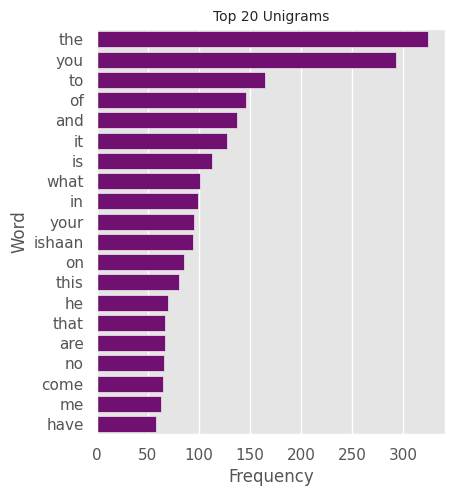

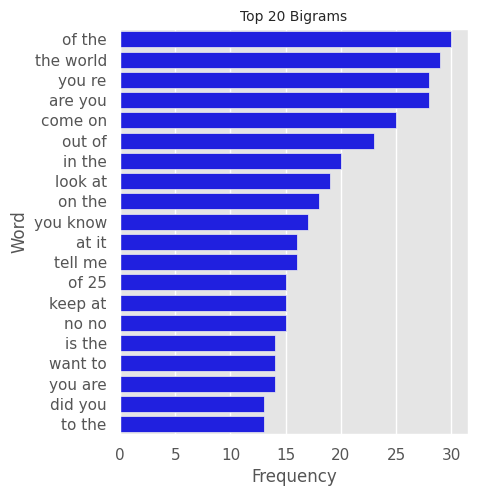

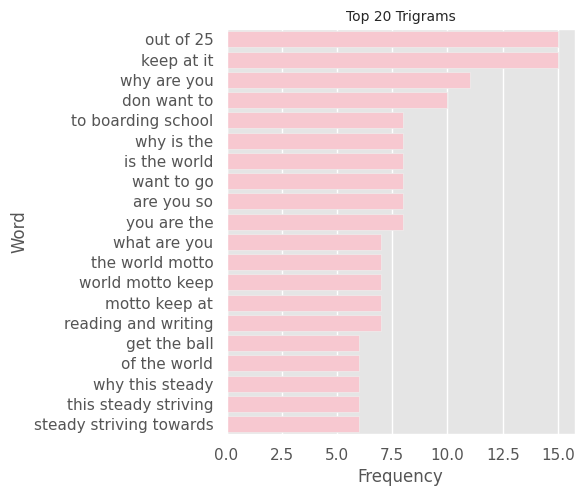

In [96]:
# Extracting raw text from the subtitles
sub_list = [ subs[i].text_without_tags for i in range(len(subs)) ]
raw_text = " ".join([str(item) for item in sub_list])

# Get unigram, bigrams and trigrams; Store them along with their frequencies in a Dictionary
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)

    df = pd.DataFrame({'Word': words, 'Frequency': freqs})
    return df

unigrams = get_top_ngrams(sub_list, (1, 1), None, 20)
bigrams = get_top_ngrams(sub_list, (2, 2), None, 20)
trigrams = get_top_ngrams(sub_list, (3, 3), None, 20)

# Plotting the popular n-grams vs their frequencies
plt.figure(figsize=(4, 5))
sns.barplot(x='Frequency', y='Word', color='purple', data=unigrams)
plt.title('Top 20 Unigrams', size=10)
plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 5))
sns.barplot(x='Frequency', y='Word', color='blue', data=pd.DataFrame(bigrams))
plt.title('Top 20 Bigrams', size=10)
plt.show()

plt.figure(figsize=(4, 5))
sns.barplot(x='Frequency', y='Word', color='pink', data=trigrams)
plt.title('Top 20 Trigrams', size=10)
plt.show()





*   **Unigrams**: As expected, we find frequently used pronouns, articles, and conjunctions dominating this category. These words serve as the glue that holds sentences together.

*  **Trigrams**: Interestingly, the most frequent trigrams are snippets of song choruses or memorable lines repeated throughout the subtitles.



## Word Cloud Analysis

In this visualization, we'll generate a [WordCloud](https://pypi.org/project/wordcloud/) using unigrams from the text. A word cloud is a graphical representation of word frequency in a given text where words that appear more frequently are displayed larger and more prominently. We will also remove commonly used English words, known as stopwords, to focus on the most meaningful and relevant terms.


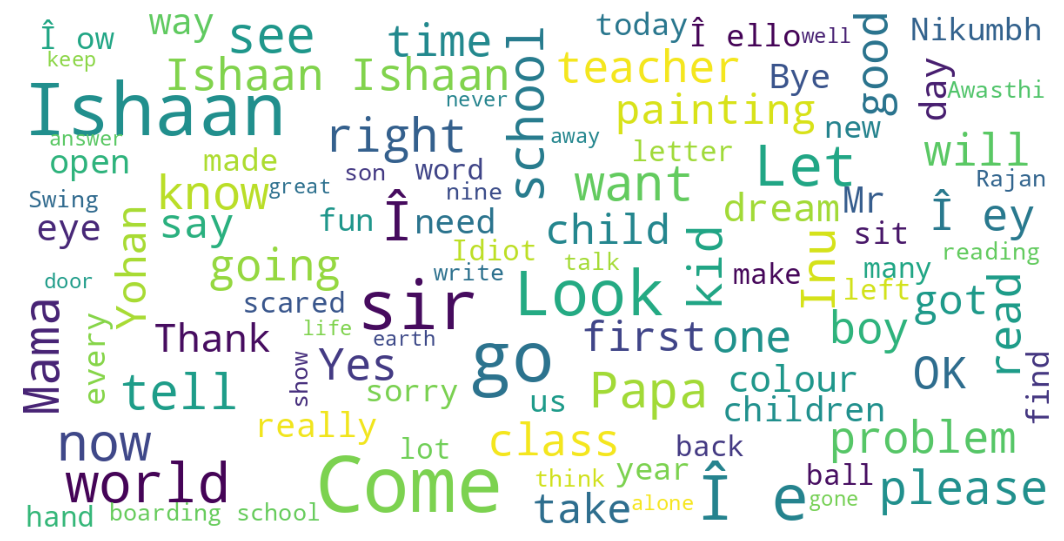

In [97]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(raw_text)



We can see from the wordcloud that parents, school activities, teacher and Ishaan are recurrent throughout the image. As it so happens, Education and Parenting are the prominent themes throughout the movie!

Also, interesting to see what would the unigram frequencies look like without the stopwords.

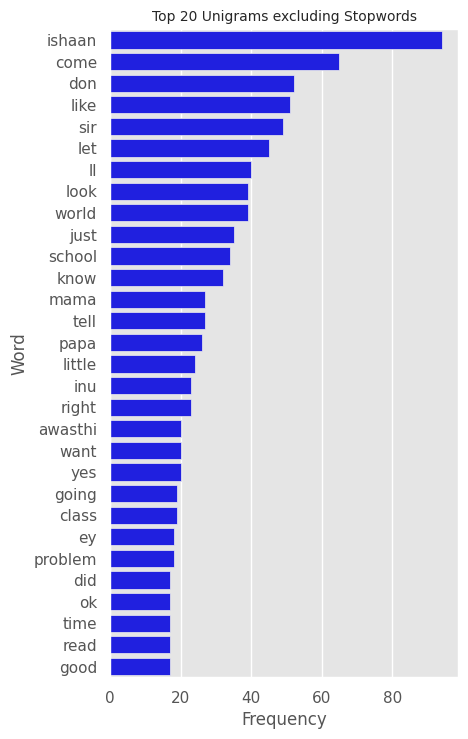

In [98]:
unigrams_nostop = get_top_ngrams(sub_list, (1, 1),'english',30)
plt.figure(figsize=(4, 8))
sns.barplot(x='Frequency', y='Word', color='blue', data=unigrams_nostop)
plt.title('Top 30 Unigrams excluding Stopwords', size=10)
plt.show()

The stopword list can be expanded by including some other common words such as 'ok'.


# Part of Speech Analysis
*   Speech (POS) Analysis using the powerful [TextBlob](https://textblob.readthedocs.io/en/dev/) library. Imagine tagging each word in the raw text extracted from the subtitle file with its grammatical role – nouns, verbs, adjectives, and more!
*   Our focus? Unveiling the main characters of the film. We'll achieve this by harnessing the power of NNP tags, which identify Proper Nouns.




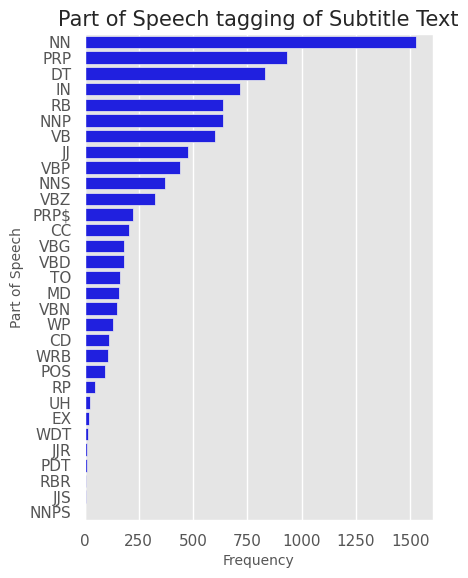

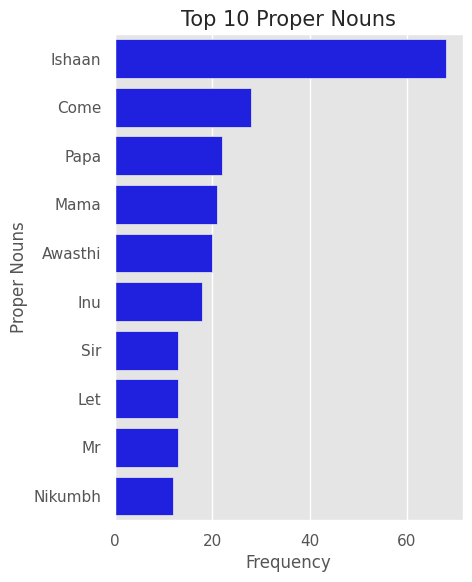

In [99]:
# POS Tags are stored in a Pandas Dataframe (like a dictionary)
blob = TextBlob(raw_text)
pos_df = pd.DataFrame(blob.tags, columns=['word', 'pos'])
top_pos = pos_df['pos'].value_counts()

#Plot the POS vs. Frequency
plt.figure(figsize=(4, 6))
sns.barplot(y=top_pos.index, x=top_pos.values, color='blue')
plt.title('Part of Speech tagging of Subtitle Text', size=15)
plt.xlabel('Frequency', fontsize=10)
plt.ylabel('Part of Speech', fontsize=10)
plt.show()

nnps = pos_df[pos_df['pos'] == 'NNP']
# Get the top 10 Proper Nouns
top_nnps = nnps['word'].value_counts().head(10)

plt.figure(figsize=(4, 6))
sns.barplot(y=top_nnps.index, x=top_nnps.values, color='blue')
plt.title('Top 10 Proper Nouns', size=15)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Proper Nouns', fontsize=12)
plt.show()




Although our POS tagger isn't as accurate, we are still able to identify some of the important characters in the film including Ishaan (or Inu), Mr. Awasthi and Nikumbh!

# Sentiment Analysis

Next, we will analyse how the mood or the sentiment of the movie fluctuates throughout its runtime!

Our method will be as follows:
*   Divide total running time to constant time intervals:
Break down the total running time of the film into fixed intervals.
*   Collect and combine all the text in each time interval:
Gather and merge all the text occurring within each time interval.
*   Find the sentiment polarity of text in each time interval using TextBlob's pretrained model
*   Create visual representations, such as charts or graphs, to illustrate the sentiment polarity trends over time intervals.



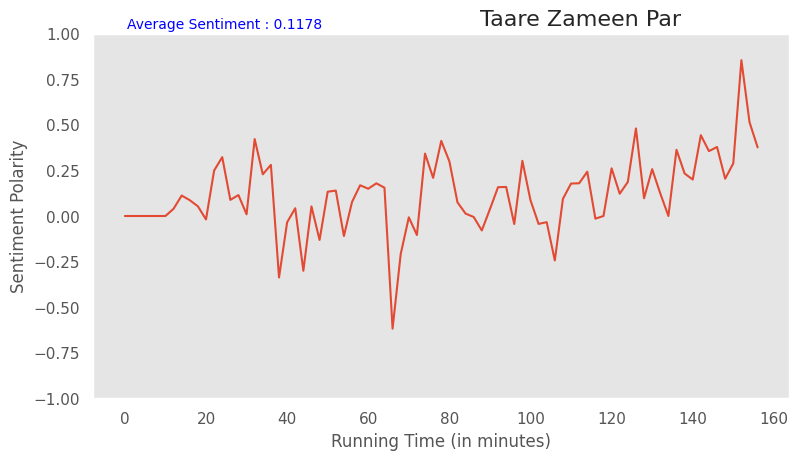

In [100]:
# Helper Function to create equally divided time intervals
# start - Starting Time
# end - Ending Time
# delta - Interval Period
def create_intervals(start, end, delta):
    curr = start
    while curr <= end:
        curr = (datetime.combine(date.today(), curr) + delta).time()
        yield curr

# Main Function to Get Sentiment Data
# subs - Subtitle list
# delta - time interval in minutes
def get_sentiment(subs, delta=2):
    # Reading Subtitle
    n = len(subs)
    # List to store the time periods
    intervals = []
    # Start, End and Delta
    start = time(0, 0, 0)
    end = subs[-1].end.to_time()
    delta = timedelta(minutes=delta)
    for result in create_intervals(start, end, delta):
        intervals.append(result)
    # List to store sentiment polarity
    sentiments = []

    index = 0
    m = len(intervals)
    # Collect and combine all the text in each time interval
    for i in range(m):
        text = ""
        for j in range(index, n):
            # Finding all subtitle text in the each time interval
            if subs[j].end.to_time() < intervals[i]:
                text += subs[j].text_without_tags + " "
            else:
                break
        # Sentiment Analysis using TextBlob
        blob = TextBlob(text)
        pol = blob.sentiment.polarity
        sentiments.append(pol)
        index = j
    # Adding Initial State
    sentiments.insert(0, 0.0)
    intervals = [2*i for i in range(len(sentiments))]
    return (intervals, sentiments)

# Helper function to plot the visualisation
def plot_sentiments(x,y):
  fig, ax = plt.subplots()
  plt.plot(x, y)
  plt.title("Taare Zameen Par", fontsize=16)
  plt.ylim((-1, 1))
  plt.ylabel("Sentiment Polarity")
  plt.xlabel("Running Time (in minutes)")
  plt.text(.5, 1.03, "Average Sentiment : " + str(round(float(sum(y))/len(y), 4)), color="blue")
  plt.grid(False)
  ttl = ax.title
  ttl.set_position([.7, 1.05])

plot_sentiments(x=get_sentiment(subs)[0],y=get_sentiment(subs)[1])

We observe that the sentiment polarity fluctuates greatly throughout the movie. Those familiar with the movie can relate to the general trends seen here. The sentiment is largely negative in the 40-60 minute range ( where Ishaan struggles at his new boarding school ) but the sentiment has a net upwards trend from here and peaks as he wins the Annual Art Competition at the end!